In [2]:
import xarray as xr
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from climada.util.constants import SYSTEM_DIR

# --- CONFIG ---
model = "CESM2"
scenario = "ssp245"
period = "base"
rp_key = "rp_100"
region_bounds = {"Caribbean": [-100, -40, 5, 40]}
selected_region = "Caribbean"

# --- PATHS ---
haz_dir = SYSTEM_DIR / "hazard" / "future" / "CHAZ_update" / "maps"
shapefile_path = SYSTEM_DIR / "ne_10m_land" / "ne_10m_land.shp"
netcdf_path = haz_dir / f"TC_global_0300as_CHAZ_{model}_{period}_{scenario}_80ens_CRH_H08_exceedance_intensity.nc"

# --- LOAD LAND SHAPE ---
land = gpd.read_file(shapefile_path).to_crs("EPSG:4326")

# --- LOAD DATA ---
ds = xr.open_dataset(netcdf_path)
lat = ds["lat"].values
lon = ds["lon"].values
values = ds[rp_key].values

# --- CREATE GEODATAFRAME ---
df = pd.DataFrame({"lat": lat, "lon": lon, "value": values})
df["geometry"] = [Point(xy) for xy in zip(df.lon, df.lat)]
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# --- CLIP TO LAND ---
gdf = gpd.clip(gdf, land)

# --- FILTER TO REGION ---
min_lon, max_lon, min_lat, max_lat = region_bounds[selected_region]
gdf = gdf.cx[min_lon:max_lon, min_lat:max_lat]


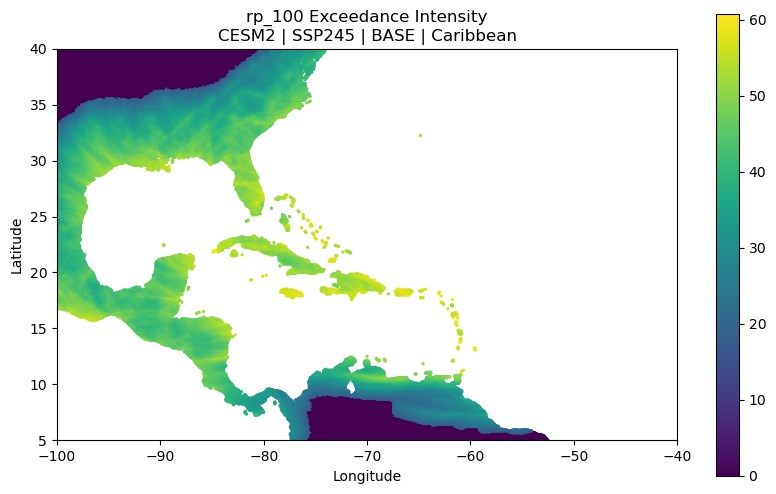

In [3]:
# --- PLOT ---
fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(column="value", cmap="viridis", markersize=2, ax=ax, legend=True)
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)
ax.set_title(f"{rp_key} Exceedance Intensity\n{model} | {scenario.upper()} | {period.upper()} | {selected_region}")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

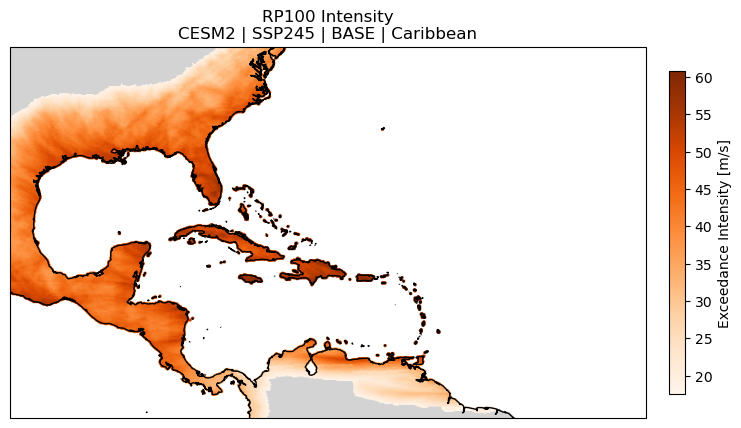

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import numpy as np

# Choose map type
is_rp_map = False  # set False for intensity

# Choose colormap
cmap_name = "Blues" if is_rp_map else "Oranges"
cmap = plt.get_cmap(cmap_name).copy()
cmap.set_bad("lightgrey")  # grey for masked areas (like zero)

# Mask 0 or NaN values
masked_vals = np.ma.masked_where((gdf["value"] <= 0) | (gdf["value"].isna()), gdf["value"])

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

sc = ax.scatter(
    gdf["lon"], gdf["lat"], c=masked_vals,
    cmap=cmap, s=2, transform=ccrs.PlateCarree()
)

ax.coastlines(resolution='10m')
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.7, pad=0.03)
cbar.set_label("Return Period [years]" if is_rp_map else "Exceedance Intensity [m/s]")

title_type = "Return Period" if is_rp_map else "RP100 Intensity"
ax.set_title(f"{title_type}\n{model} | {scenario.upper()} | {period.upper()} | {selected_region}")
plt.show()


## Return period maps of Cat. 1 TCs

In [5]:
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.geometry import Point
from climada.util.constants import SYSTEM_DIR

# --- CONFIG ---
models = [
    "CESM2", "CNRM-CM6-1", "EC-Earth3", "IPSL-CM6A-LR",
    "MIROC6", "MPI-ESM1-2-HR", "UKESM1-0-LL"
]
scenarios = ["ssp245", "ssp370", "ssp585"]
periods = ["base", "fut1", "fut2"]
tcgi = "CRH"
threshold = 33
rp_key = f"thr_{threshold}"
region_bounds = {
    "Caribbean": [-100, -40, 5, 40],
    "Southeast Asia": [90, 150, 5, 30],
    "Global": [-180, 180, -90, 90]
}
selected_region = "Caribbean"
haz_dir = SYSTEM_DIR / "hazard" / "future" / "CHAZ_update" / "maps"
shapefile_path = SYSTEM_DIR / "ne_10m_land" / "ne_10m_land.shp"
land = gpd.read_file(shapefile_path).to_crs("EPSG:4326")
min_lon, max_lon, min_lat, max_lat = region_bounds[selected_region]


Compute multi-model medians

In [6]:
# Store median GeoDataFrames per period/scenario
median_maps = {}

for period in periods:
    for scenario in scenarios:
        all_model_vals = []

        for model in models:
            file = f"TC_global_0300as_CHAZ_{model}_{period}_{scenario}_80ens_{tcgi}_H08_return_periods.nc"
            path = haz_dir / file
            if not path.exists():
                continue

            try:
                ds = xr.open_dataset(path)
                if rp_key not in ds:
                    continue

                df = pd.DataFrame({
                    "lat": ds["lat"].values,
                    "lon": ds["lon"].values,
                    rp_key: ds[rp_key].values
                })
                df["geometry"] = [Point(xy) for xy in zip(df.lon, df.lat)]
                gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

                gdf = gpd.clip(gdf, land)
                gdf = gdf.cx[min_lon:max_lon, min_lat:max_lat]

                if not gdf.empty:
                    gdf = gdf.set_index(["lat", "lon"])
                    all_model_vals.append(gdf[rp_key])

            except Exception as e:
                print(f"Error loading {file}: {e}")

        if all_model_vals:
            merged = pd.concat(all_model_vals, axis=1)
            median_vals = merged.median(axis=1).reset_index()
            median_vals.rename(columns={0: rp_key}, inplace=True)
            median_vals["geometry"] = [Point(xy) for xy in zip(median_vals.lon, median_vals.lat)]
            gdf_median = gpd.GeoDataFrame(median_vals, geometry="geometry", crs="EPSG:4326")
            median_maps[(period, scenario)] = gdf_median


Plot single map

Plot all subplots over scenarios and future periods

/var/folders/7j/w3ygw9_d0wb9dn7w0f21n_980000gn/T/ipykernel_36005/3692968542.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.03, 0.12, 1, 1])


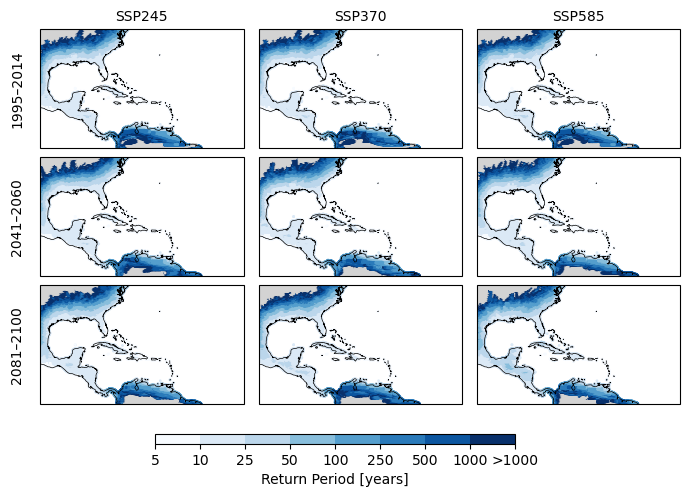

In [7]:
import matplotlib.colors as mcolors
from pathlib import Path

# --- Bin settings ---
bins = [5, 10, 25, 50, 100, 250, 500, 1000, 10000]
log_bins = np.log10(bins)
tick_labels = [str(b) for b in bins[:-1]] + [">1000"]
norm = mcolors.BoundaryNorm(log_bins, ncolors=len(bins) - 1)
cmap = plt.get_cmap("Blues", len(bins) - 1)
cmap.set_bad("lightgrey")

# --- Period labels ---
period_labels = {
    "base": "1995–2014",
    "fut1": "2041–2060",
    "fut2": "2081–2100"
}
fontsize = 10

# --- Plot ---
fig, axes = plt.subplots(3, 3, figsize=(7.2, 4.8), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(wspace=0.05, hspace=0.15)

scatter_ref = None

for i, period in enumerate(periods):
    for j, scenario in enumerate(scenarios):
        ax = axes[i, j]
        gdf = median_maps.get((period, scenario))

        if gdf is not None:
            log_vals = np.log10(gdf[rp_key])
            masked_vals = np.ma.masked_where((log_vals <= 0) | (log_vals.isna()), log_vals)

            sc = ax.scatter(
                gdf["lon"], gdf["lat"], c=masked_vals,
                cmap=cmap, s=1, transform=ccrs.PlateCarree(), norm=norm
            )
            if scatter_ref is None:
                scatter_ref = sc

        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)

        if i == 0:
            ax.set_title(scenario.upper(), fontsize=fontsize)

        if j == 0:
            ax.text(
                -0.08, 0.5, period_labels[period],
                transform=ax.transAxes, rotation=90,
                fontsize=fontsize, va='center', ha='right'
            )

# --- Colorbar ---
if scatter_ref is not None:
    cbar_ax = fig.add_axes([0.25, 0.07, 0.5, 0.02])
    cbar = fig.colorbar(scatter_ref, cax=cbar_ax, orientation='horizontal', ticks=log_bins)
    cbar.ax.set_xticklabels(tick_labels)
    cbar.set_label("Return Period [years]", fontsize=fontsize)
else:
    print("⚠️ No valid data to plot — skipping colorbar.")

plt.tight_layout(rect=[0.03, 0.12, 1, 1])
plt.show()

# --- Optional: Save the figure ---
save_fig = True  # Set to False to skip saving

if save_fig:
    output_path = Path(f"/Users/simonameiler/Documents/work/03_code/repos/CHAZ-hazard-maps/CHAZ-hazard-maps/figures/rp_map_3x3_thr{threshold}_{tcgi}_{selected_region}.png")
    fig.savefig(output_path, dpi=300, bbox_inches='tight')


#### Difference plots

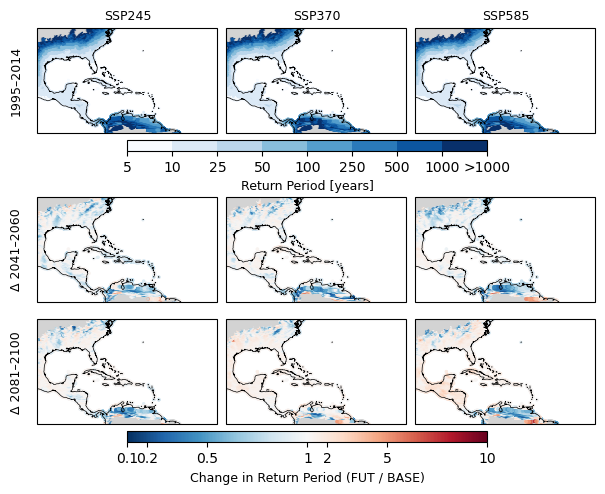

✅ Saved: /Users/simonameiler/Documents/work/03_code/repos/CHAZ-hazard-maps/CHAZ-hazard-maps/figures/rp_ratio_thr_33_CRH.png


In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import numpy as np
from pathlib import Path

# --- Setup ---
fontsize = 9
fig = plt.figure(figsize=(7.2, 5.2))
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[1, 0.3, 1, 1], wspace=0.05, hspace=0.15)

# RP absolute color settings (baseline RP)
bins = [5, 10, 25, 50, 100, 250, 500, 1000, 10000]
log_bins = np.log10(bins)
tick_labels = [str(b) for b in bins[:-1]] + [">1000"]
norm_abs = mcolors.BoundaryNorm(log_bins, ncolors=len(bins) - 1)
cmap_abs = plt.get_cmap("Blues", len(bins) - 1)
cmap_abs.set_bad("lightgrey")

# RP ratio color settings (FUT / BASE)
cmap_diff = plt.get_cmap("RdBu_r").copy()
cmap_diff.set_bad("lightgrey")
norm_diff = mcolors.TwoSlopeNorm(vmin=0.1, vcenter=1, vmax=10)

# Periods and labels
periods = ["base", "fut1", "fut2"]
period_labels = {
    "base": "1995–2014",
    "fut1": "Δ 2041–2060",
    "fut2": "Δ 2081–2100"
}

scatter_refs = {"abs": None, "diff": None}

for i, period in enumerate(periods):
    for j, scenario in enumerate(scenarios):
        row_idx = i if i == 0 else i + 1  # spacer row at index 1
        ax = fig.add_subplot(gs[row_idx, j], projection=ccrs.PlateCarree())

        gdf = median_maps.get((period, scenario))
        gdf_base = median_maps.get(("base", scenario)) if period != "base" else None

        if gdf is not None:
            if period == "base":
                log_vals = np.log10(gdf[rp_key])
                masked_vals = np.ma.masked_where((log_vals <= 0) | (log_vals.isna()), log_vals)

                sc = ax.scatter(
                    gdf["lon"], gdf["lat"], c=masked_vals,
                    cmap=cmap_abs, s=1, transform=ccrs.PlateCarree(), norm=norm_abs
                )
                if scatter_refs["abs"] is None:
                    scatter_refs["abs"] = sc
            elif gdf_base is not None:
                # Compute FUT / BASE ratio
                df_merged = gdf.set_index(["lat", "lon"]).join(
                    gdf_base.set_index(["lat", "lon"]),
                    lsuffix="_fut", rsuffix="_base"
                )
                val_fut = df_merged[f"{rp_key}_fut"]
                val_base = df_merged[f"{rp_key}_base"]
                ratio = val_fut / val_base
                ratio = ratio.clip(lower=0.1, upper=10)
                masked_vals = np.ma.masked_where(ratio.isna(), ratio)

                coords = df_merged.index.to_frame(index=False)

                sc = ax.scatter(
                    coords["lon"], coords["lat"], c=masked_vals,
                    cmap=cmap_diff, norm=norm_diff,
                    s=2, transform=ccrs.PlateCarree()
                )
                if scatter_refs["diff"] is None:
                    scatter_refs["diff"] = sc

        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)

        if i == 0:
            ax.set_title(scenario.upper(), fontsize=fontsize)

        if j == 0:
            ax.text(
                -0.08, 0.5, period_labels[period],
                transform=ax.transAxes, rotation=90,
                fontsize=fontsize, va='center', ha='right'
            )

# --- Colorbars ---
if scatter_refs["abs"] is not None:
    cbar_ax_abs = fig.add_axes([0.25, 0.64, 0.5, 0.02])
    cbar = fig.colorbar(scatter_refs["abs"], cax=cbar_ax_abs, orientation='horizontal', ticks=log_bins)
    cbar.ax.set_xticklabels(tick_labels)
    cbar.set_label("Return Period [years]", fontsize=fontsize)

if scatter_refs["diff"] is not None:
    cbar_ax_diff = fig.add_axes([0.25, 0.08, 0.5, 0.02])
    cbar_diff = fig.colorbar(scatter_refs["diff"], cax=cbar_ax_diff, orientation='horizontal')
    cbar_diff.set_ticks([0.1, 0.2, 0.5, 1, 2, 5, 10])
    cbar_diff.set_ticklabels(["0.1", "0.2", "0.5", "1", "2", "5", "10"])
    cbar_diff.set_label("Change in Return Period (FUT / BASE)", fontsize=fontsize)

plt.show()

# --- Save ---
save_fig = True
if save_fig:
    output_path = Path(f"/Users/simonameiler/Documents/work/03_code/repos/CHAZ-hazard-maps/CHAZ-hazard-maps/figures/rp_ratio_{rp_key}_{tcgi}.png")
    fig.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {output_path}")


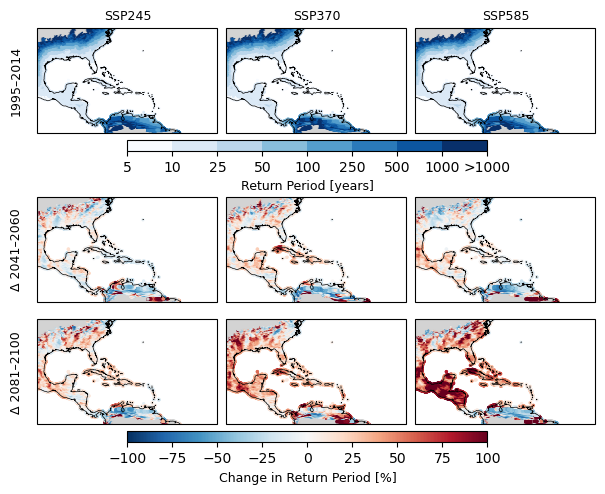

✅ Saved: /Users/simonameiler/Documents/work/03_code/repos/CHAZ-hazard-maps/CHAZ-hazard-maps/figures/rp_diff_pct_thr_33_CRH_Caribbean.png


In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import numpy as np
from pathlib import Path

# --- Setup ---
fontsize = 9
fig = plt.figure(figsize=(7.2, 5.2))
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[1, 0.3, 1, 1], wspace=0.05, hspace=0.15)

# RP settings
bins = [5, 10, 25, 50, 100, 250, 500, 1000, 10000]
log_bins = np.log10(bins)
tick_labels = [str(b) for b in bins[:-1]] + [">1000"]
norm = mcolors.BoundaryNorm(log_bins, ncolors=len(bins) - 1)
cmap_abs = plt.get_cmap("Blues", len(bins) - 1)
cmap_abs.set_bad("lightgrey")

# % diff colorbar
cmap_diff = plt.get_cmap("RdBu_r").copy()
cmap_diff.set_bad("lightgrey")
vmin_pct, vmax_pct = -100, 100  # clip percent changes

periods = ["base", "fut1", "fut2"]
period_labels = {
    "base": "1995–2014",
    "fut1": "Δ 2041–2060",
    "fut2": "Δ 2081–2100"
}

scatter_refs = {"abs": None, "diff": None}

for i, period in enumerate(periods):
    for j, scenario in enumerate(scenarios):
        row_idx = i if i == 0 else i + 1  # adjust for spacer
        ax = fig.add_subplot(gs[row_idx, j], projection=ccrs.PlateCarree())

        gdf = median_maps.get((period, scenario))
        gdf_base = median_maps.get(("base", scenario)) if period != "base" else None

        if gdf is not None:
            if period == "base":
                log_vals = np.log10(gdf[rp_key])
                masked_vals = np.ma.masked_where((log_vals <= 0) | (log_vals.isna()), log_vals)

                sc = ax.scatter(
                    gdf["lon"], gdf["lat"], c=masked_vals,
                    cmap=cmap_abs, s=1, transform=ccrs.PlateCarree(), norm=norm
                )
                if scatter_refs["abs"] is None:
                    scatter_refs["abs"] = sc
            elif gdf_base is not None:
                df_merged = gdf.set_index(["lat", "lon"]).join(
                    gdf_base.set_index(["lat", "lon"]),
                    lsuffix="_fut", rsuffix="_base"
                )
                base_vals = df_merged[f"{rp_key}_base"]
                fut_vals = df_merged[f"{rp_key}_fut"]

                pct_change = ((fut_vals - base_vals) / base_vals) * 100
                pct_change = pct_change.clip(lower=vmin_pct, upper=vmax_pct)
                masked_vals = np.ma.masked_where(pct_change.isna(), pct_change)

                coords = df_merged.index.to_frame(index=False)
                sc = ax.scatter(
                    coords["lon"], coords["lat"], c=masked_vals,
                    cmap=cmap_diff, vmin=vmin_pct, vmax=vmax_pct,
                    s=2, transform=ccrs.PlateCarree()
                )
                if scatter_refs["diff"] is None:
                    scatter_refs["diff"] = sc

        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)

        if i == 0:
            ax.set_title(scenario.upper(), fontsize=fontsize)

        if j == 0:
            ax.text(
                -0.08, 0.5, period_labels[period],
                transform=ax.transAxes, rotation=90,
                fontsize=fontsize, va='center', ha='right'
            )

# --- Colorbars ---
if scatter_refs["abs"] is not None:
    cbar_ax_abs = fig.add_axes([0.25, 0.64, 0.5, 0.02])
    cbar = fig.colorbar(scatter_refs["abs"], cax=cbar_ax_abs, orientation='horizontal', ticks=log_bins)
    cbar.ax.set_xticklabels(tick_labels)
    cbar.set_label("Return Period [years]", fontsize=fontsize)

if scatter_refs["diff"] is not None:
    cbar_ax_diff = fig.add_axes([0.25, 0.08, 0.5, 0.02])
    cbar_diff = fig.colorbar(scatter_refs["diff"], cax=cbar_ax_diff, orientation='horizontal')
    cbar_diff.set_label("Change in Return Period [%]", fontsize=fontsize)

plt.show()

# --- Save option ---
save_fig = True
if save_fig:
    output_path = Path(f"/Users/simonameiler/Documents/work/03_code/repos/CHAZ-hazard-maps/CHAZ-hazard-maps/figures/rp_diff_pct_{rp_key}_{tcgi}_{selected_region}.png")
    fig.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {output_path}")


## Exceedance intensity maps for RP100

In [10]:
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from climada.util.constants import SYSTEM_DIR

# --- CONFIG ---
models = [
    "CESM2", "CNRM-CM6-1", "EC-Earth3", "IPSL-CM6A-LR",
    "MIROC6", "MPI-ESM1-2-HR", "UKESM1-0-LL"
]
scenarios = ["ssp245", "ssp370", "ssp585"]
periods = ["base", "fut1", "fut2"]
tcgi = "SD"
rp_key = "rp_100"
haz_dir = SYSTEM_DIR / "hazard" / "future" / "CHAZ_update" / "maps"
shapefile_path = SYSTEM_DIR / "ne_10m_land" / "ne_10m_land.shp"
region_bounds = {
    "Caribbean": [-100, -40, 5, 40],
    "Southeast Asia": [90, 150, 5, 30],
    "Global": [-180, 180, -90, 90]
}
selected_region = "Southeast Asia"
land = gpd.read_file(shapefile_path).to_crs("EPSG:4326")
min_lon, max_lon, min_lat, max_lat = region_bounds[selected_region]

In [11]:
median_maps_intensity = {}

for period in periods:
    for scenario in scenarios:
        all_model_vals = []

        for model in models:
            file = f"TC_global_0300as_CHAZ_{model}_{period}_{scenario}_80ens_{tcgi}_H08_exceedance_intensity.nc"
            path = haz_dir / file
            if not path.exists():
                continue

            try:
                ds = xr.open_dataset(path)
                if rp_key not in ds:
                    continue

                df = pd.DataFrame({
                    "lat": ds["lat"].values,
                    "lon": ds["lon"].values,
                    rp_key: ds[rp_key].values
                })
                df["geometry"] = [Point(xy) for xy in zip(df.lon, df.lat)]
                gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

                gdf = gpd.clip(gdf, land)
                gdf = gdf.cx[min_lon:max_lon, min_lat:max_lat]

                if not gdf.empty:
                    gdf = gdf.set_index(["lat", "lon"])
                    all_model_vals.append(gdf[rp_key])

            except Exception as e:
                print(f"Error loading {file}: {e}")

        if all_model_vals:
            merged = pd.concat(all_model_vals, axis=1)
            median_vals = merged.median(axis=1).reset_index()
            median_vals.rename(columns={0: rp_key}, inplace=True)
            median_vals["geometry"] = [Point(xy) for xy in zip(median_vals.lon, median_vals.lat)]
            gdf_median = gpd.GeoDataFrame(median_vals, geometry="geometry", crs="EPSG:4326")
            median_maps_intensity[(period, scenario)] = gdf_median


Plot single map

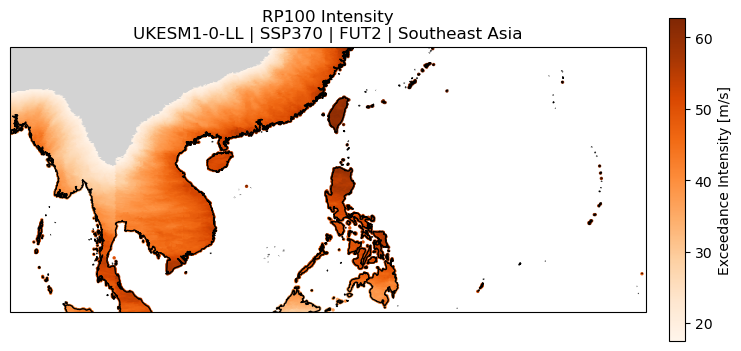

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

# Choose an example to visualize
period = "fut2"
scenario = "ssp370"
gdf = median_maps_intensity[(period, scenario)]

# --- Plot setup ---
cmap = plt.get_cmap("Oranges").copy()
cmap.set_bad("lightgrey")

# Mask 0/NaN
masked_vals = np.ma.masked_where((gdf[rp_key] <= 0) | (gdf[rp_key].isna()), gdf[rp_key])

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
sc = ax.scatter(
    gdf["lon"], gdf["lat"], c=masked_vals,
    cmap=cmap, s=2, transform=ccrs.PlateCarree()
)

ax.coastlines(resolution='10m')
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.7, pad=0.03)
cbar.set_label("Return Period [years]" if is_rp_map else "Exceedance Intensity [m/s]")

title_type = "Return Period" if is_rp_map else "RP100 Intensity"
ax.set_title(f"{title_type}\n{model} | {scenario.upper()} | {period.upper()} | {selected_region}")
plt.show()


Plot all subplots over scenarios and future periods

/var/folders/7j/w3ygw9_d0wb9dn7w0f21n_980000gn/T/ipykernel_36005/3916953438.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.03, 0.12, 1, 1])


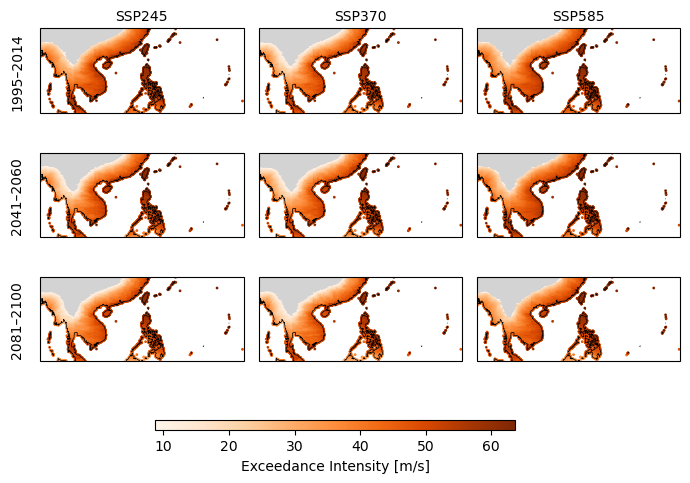

In [13]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# --- Style ---
fontsize = 10
cmap = plt.get_cmap("Oranges").copy()
cmap.set_bad("lightgrey")

# --- Period label mapping ---
period_labels = {
    "base": "1995–2014",
    "fut1": "2041–2060",
    "fut2": "2081–2100"
}

# --- Figure ---
fig, axes = plt.subplots(3, 3, figsize=(7.2, 4.8), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(wspace=0.05, hspace=0.15)

scatter_ref = None

for i, period in enumerate(periods):
    for j, scenario in enumerate(scenarios):
        ax = axes[i, j]
        gdf = median_maps_intensity.get((period, scenario))

        if gdf is not None:
            masked_vals = np.ma.masked_where((gdf[rp_key] <= 0) | (gdf[rp_key].isna()), gdf[rp_key])

            sc = ax.scatter(
                gdf["lon"], gdf["lat"], c=masked_vals,
                cmap=cmap, s=1, transform=ccrs.PlateCarree()
            )
            if scatter_ref is None:
                scatter_ref = sc

        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)

        # Column titles (scenarios)
        if i == 0:
            ax.set_title(scenario.upper(), fontsize=fontsize)

        # Row labels (periods)
        if j == 0:
            ax.text(
                -0.08, 0.5, period_labels[period],
                transform=ax.transAxes, rotation=90,
                fontsize=fontsize, va='center', ha='right'
            )

# --- Shared colorbar below ---
if scatter_ref is not None:
    cbar_ax = fig.add_axes([0.25, 0.07, 0.5, 0.02])
    cbar = fig.colorbar(scatter_ref, cax=cbar_ax, orientation='horizontal')
    cbar.set_label("Exceedance Intensity [m/s]", fontsize=fontsize)
else:
    print("⚠️ No valid data to plot — skipping colorbar.")

plt.tight_layout(rect=[0.03, 0.12, 1, 1])
plt.show()

# --- Save to file ---
save_fig = True
if save_fig:
    output_path = Path(f"/Users/simonameiler/Documents/work/03_code/repos/CHAZ-hazard-maps/CHAZ-hazard-maps/figures/exceedance_intensity_{rp_key}_{tcgi}_{selected_region}.png")
    fig.savefig(output_path, dpi=300, bbox_inches='tight')


#### Difference plots

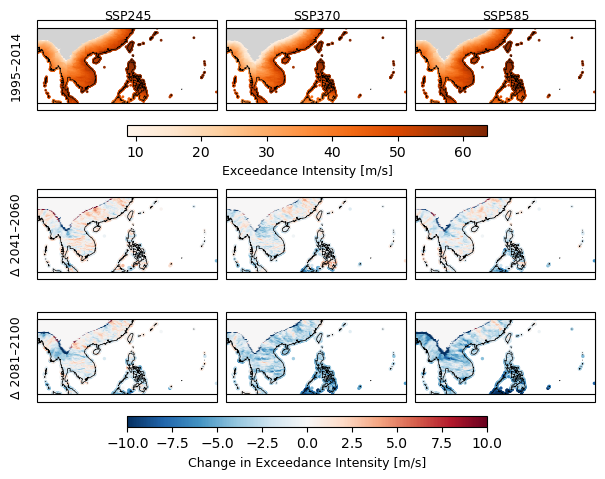

In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import numpy as np

# --- Styling and layout ---
fontsize = 9
fig = plt.figure(figsize=(7.2, 5.2))
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[1, 0.3, 1, 1], wspace=0.05, hspace=0.15)

period_rows = ["base", "fut1", "fut2"]
period_labels = {
    "base": "1995–2014",
    "fut1": "Δ 2041–2060",
    "fut2": "Δ 2081–2100"
}

# Colormaps
cmap_abs = plt.get_cmap("Oranges").copy()
cmap_abs.set_bad("lightgrey")
cmap_diff = plt.get_cmap("RdBu_r").copy()
cmap_diff.set_bad("lightgrey")
vmin_diff, vmax_diff = -10, 10

scatter_refs = {"abs": None, "diff": None}

for i, period in enumerate(["base", "fut1", "fut2"]):
    for j, scenario in enumerate(scenarios):
        # Compute the correct row index in GridSpec
        row_idx = i if i == 0 else i + 1  # i=1 (fut1) → row 2, i=2 (fut2) → row 3
        ax = fig.add_subplot(gs[row_idx, j], projection=ccrs.PlateCarree())


        # Adjust row index in GridSpec: row 0 → base, 2 → fut1, 3 → fut2
        row_idx = i if i == 0 else i + 1
        ax = fig.add_subplot(gs[row_idx, j], projection=ccrs.PlateCarree())

        gdf = median_maps_intensity.get((period, scenario))
        gdf_base = median_maps_intensity.get(("base", scenario)) if period != "base" else None

        if gdf is not None:
            if period == "base":
                masked_vals = np.ma.masked_where((gdf[rp_key] <= 0) | (gdf[rp_key].isna()), gdf[rp_key])
                sc = ax.scatter(
                    gdf["lon"], gdf["lat"], c=masked_vals,
                    cmap=cmap_abs, s=1, transform=ccrs.PlateCarree()
                )
                if scatter_refs["abs"] is None:
                    scatter_refs["abs"] = sc
            else:
                df_merged = gdf.set_index(["lat", "lon"]).join(
                    gdf_base.set_index(["lat", "lon"]),
                    lsuffix="_fut", rsuffix="_base"
                )
                diff_vals = df_merged[f"{rp_key}_fut"] - df_merged[f"{rp_key}_base"]
                masked_vals = np.ma.masked_where(diff_vals.isna(), diff_vals)

                coords = df_merged.index.to_frame(index=False)
                sc = ax.scatter(
                    coords["lon"], coords["lat"], c=masked_vals,
                    cmap=cmap_diff, vmin=vmin_diff, vmax=vmax_diff,
                    s=2, transform=ccrs.PlateCarree()
                )
                if scatter_refs["diff"] is None:
                    scatter_refs["diff"] = sc

        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)

        if i == 0:
            ax.set_title(scenario.upper(), fontsize=fontsize)

        if j == 0:
            ax.text(
                -0.08, 0.5, period_labels[period],
                transform=ax.transAxes, rotation=90,
                fontsize=fontsize, va='center', ha='right'
            )

# --- Colorbars ---
if scatter_refs["abs"] is not None:
    cbar_ax_abs = fig.add_axes([0.25, 0.64, 0.5, 0.02])
    cbar = fig.colorbar(scatter_refs["abs"], cax=cbar_ax_abs, orientation='horizontal')
    cbar.set_label("Exceedance Intensity [m/s]", fontsize=fontsize)

if scatter_refs["diff"] is not None:
    cbar_ax_diff = fig.add_axes([0.25, 0.08, 0.5, 0.02])
    cbar_diff = fig.colorbar(scatter_refs["diff"], cax=cbar_ax_diff, orientation='horizontal')
    cbar_diff.set_label("Change in Exceedance Intensity [m/s]", fontsize=fontsize)

#plt.tight_layout(rect=[0.03, 0.14, 1, 0.95])
plt.show()

# --- Save to file ---
save_fig = True
if save_fig:
    output_path = Path(f"/Users/simonameiler/Documents/work/03_code/repos/CHAZ-hazard-maps/CHAZ-hazard-maps/figures/exceedance_intensity_diff_{rp_key}_{tcgi}_{selected_region}.png")
    fig.savefig(output_path, dpi=300, bbox_inches='tight')

